#Fourier power spectrums from the maps

##Author: Bruno Bizarria

###Date: 12/19/2022

This code obtain the autocorrelation and cross-correlation power spectruns from HI and galaxy mocks using the library Pylians (pylians3.readthedocs.io/en/master/). The basis of this code is the Jiajun Zhang code to reconstruct the 3D density field, which is within the function "Field3d". So, let's see what we will do here:

1) Obtain the HI 3D field

2) Obtain the HI 3D field with the mask

3) Calcule the 3D power spectruns with and without the mask and both with error bars

4) Calcule the 1D power spectruns with and without mask

5) Obtain dark matter 3D field and calcule bias

6) Extract BAO profile from 3D PS

7) Obtain 2D PS with mask

8) Obtain HI pipeline 3D field

9) Repeat steps 3,4,5,6 and 7

10) Obtain galaxy 3D field with DES mask

11) Calcule 3D galaxy PS

12) Calcule the galaxy 1D PS

13) Calcule the 2D galaxy PS

14) Obtain HI and galaxy 3D field with the overlap mask

15) Calcule 3D cross power spectrum with error bars

16) Calcule 1D cross power spectrum with error bars

17) Obtain HI pipeline and galaxy 3D field with the overlap mask

18) Repeat steps 15 and 16

We hope these steps can improve our undestanding of how our HI and Galaxy simulations models the observed volume, and how the cross-correlations between then behave. In addition, we attept to obtain the BAO profile in a very simple way, only to have a rough estimative of it.

In [1]:
# INSTALL PACKAGES, SYNCHRONIZE WITH YOUR GOOGLE DRIVE AND ACCESS THE FUNCTION FILE

!pip install Pylians
!pip install healpy

!pip install SciencePlots

!apt install cm-super
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#The command below is to bring the program where I define the function generate 3d field

!cp /content/drive/MyDrive/espectro_potencia/pk_functions_new.py .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.0 MB/s eta 0:00:00
  Created wheel for Pylians: filename=Pylians-0.6-cp38-cp38-linux_x86_64.whl size=9712023 sha256=228b24de128b8a8a9b901ce0ca2ff89b601d9a18a5f32548d1e2a99f4124b060
  Stored in directory: /root/.cache/pip/wheels/25/5d/57/e1106b9a6bc999d662a9da1341a39ea2d129f7265055c35b45
Successfully built Pylians
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 19.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/publi

In [ ]:
!pip install CAMB

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import healpy as hp
import math
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from matplotlib import pyplot as plt
import scienceplots
plt.style.use('science')
plt.rcParams.update({'figure.dpi': '300'})

#import camb
from astropy.cosmology import FlatLambdaCDM, z_at_value 
import Pk_library as PKL                                  #Pylians

from pk_functions_new import *                                #Functions I define in the other file

#FIRST PART: HI MOCK
STEP 1 AND 2: OBTAIN THE 3D FIELD WITH AND WITHOUT MASK 

In [6]:
path        = '/content/drive/MyDrive/mapas/21cmTb_real/'
path_mask   = '/content/drive/MyDrive/mapas/mascaras/mask_bingo.fits'
path_over   = '/content/drive/MyDrive/mapas/mascaras/mask_over.fits'
Om0         = 0.26
H0          = 72
freq_min    = 980
freq_max    = 1260
number_maps = 30
nside       = 256
nmesh       = 256
boxsize     = 3150.0
fsky        = 0.125 #Approximation of BINGO's mask
fskyo       = 0.025

cosmo = FlatLambdaCDM(Om0=Om0,H0=H0)
frequency = np.linspace(freq_min,freq_max,number_maps+1)
redshift = 1420.40575177/frequency - 1.
distance = cosmo.comoving_distance(redshift).value * cosmo.h

d_grid = Field3d(Om0,H0,freq_min,freq_max,number_maps,nside,boxsize,path)                   #3D FIELD
m_grid = Field3d_masked(Om0,H0,freq_min,freq_max,number_maps,nside,boxsize,path,path_mask)  #3D MASKED FIELD
o_grid = Field3d_masked(Om0,H0,freq_min,freq_max,number_maps,nside,boxsize,path,path_over)  #3D MASKED FIELD


Full sky 3D field calculated
Masked 3D field calculated
Masked 3D field calculated


STEP 3: 3D PS

In [7]:
# 3D P(k)

Pk_full  = PKL.Pk(np.float32(d_grid), boxsize, axis=0, MAS='None', threads=8)
k        = Pk_full.k3D
Pkf      = Pk_full.Pk[:,0]
Nmodesf  = Pk_full.Nmodes3D

Pk_mask  = PKL.Pk(np.float32(m_grid), boxsize, axis=0, MAS='None', threads=8)
km        = Pk_mask.k3D
Pkm      = Pk_mask.Pk[:,0]
Nmodesm  = Pk_mask.Nmodes3D*fsky      #One must multiply by the fsky to obtain the correct number of modes in the partial sky case

Pk_over  = PKL.Pk(np.float32(o_grid), boxsize, axis=0, MAS='None', threads=8)
ko        = Pk_over.k3D
Pko      = Pk_over.Pk[:,0]
Nmodeso  = Pk_over.Nmodes3D*fskyo      #One must multiply by the fsky to obtain the correct number of modes in the partial sky case

def variance(ps,nmodes,grid,nmesh):
  var = ps * nmesh**3. / np.count_nonzero(grid)/(nmodes)**(1/2)
  return var



Computing power spectrum of the field...
Time to complete loop = 0.77
Time taken = 1.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.71
Time taken = 1.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.72
Time taken = 1.01 seconds


In [ ]:
#plt.loglog(k,Pkf * nmesh**3. / np.count_nonzero(d_grid), label='Céu inteiro',color='g')
plt.errorbar(k,Pkf * nmesh**3. / np.count_nonzero(d_grid),yerr = Pkf * nmesh**3. / np.count_nonzero(d_grid)/(Nmodesf)**(1/2),fmt='',color='g',elinewidth=0.5,capsize=0.5,capthick=0.5,label='Céu inteiro')
#plt.loglog(k,Pkm * nmesh**3. / np.count_nonzero(m_grid), label='Área BINGO',color='b')
plt.errorbar(k,Pkm * nmesh**3. / np.count_nonzero(m_grid),yerr = (Pkm * nmesh**3. / np.count_nonzero(m_grid))/(Nmodesm)**(1/2),fmt='',color='b',elinewidth=0.5,capsize=1,capthick=0.5,label='Área BINGO')
#plt.loglog(k,Pko * nmesh**3. / np.count_nonzero(o_grid), label='Área BINGO x DES',color='r')
plt.errorbar(k,Pko * nmesh**3. / np.count_nonzero(o_grid),yerr = (Pko * nmesh**3. / np.count_nonzero(o_grid))/(Nmodeso)**(1/2),fmt='',color='r',elinewidth=0.5,capsize=1,capthick=0.5,label='Área BINGO x DES')
plt.legend(loc='lower center')
#plt.xlim(0.01,0.05)
plt.loglog()
plt.ylim(8e+2,4e+4)
plt.xlabel('k(h/Mpc)')
plt.ylabel('$Pk(Mpc^3/h^3)$')
plt.title('Espectro de potência 3D de HI')
plt.show()
#plt.savefig('/content/drive/MyDrive/imagens/resultados/teste_masks.png',dpi=300)

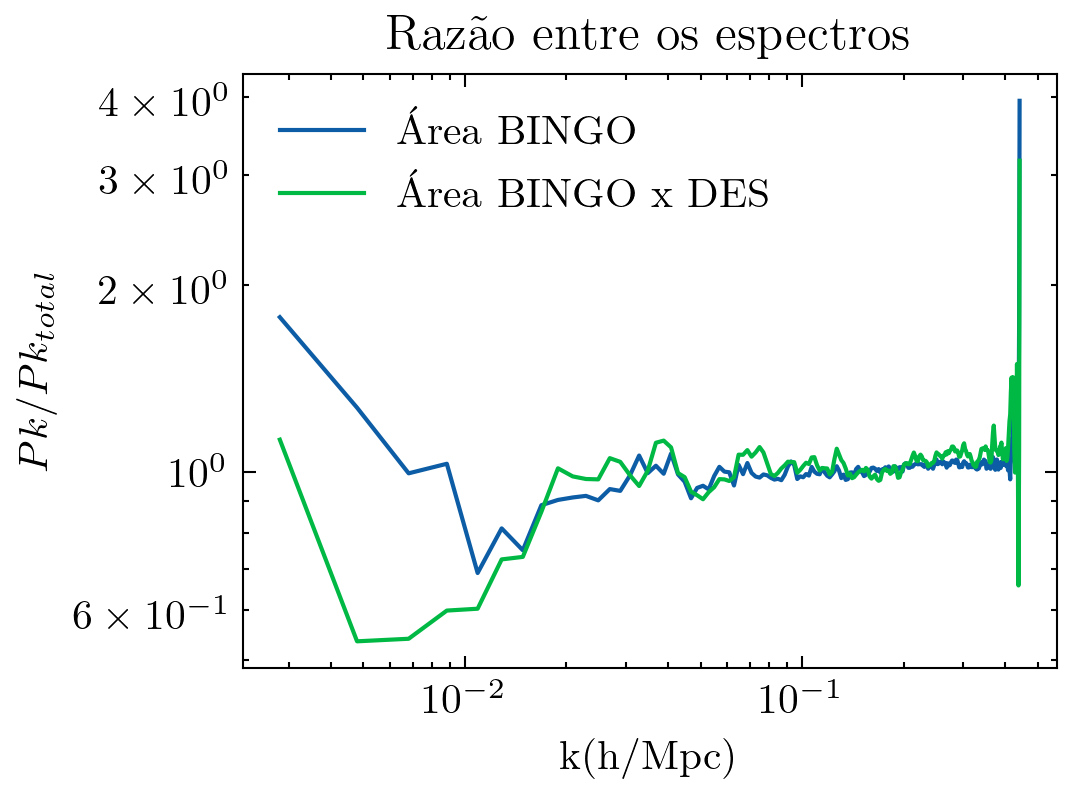

In [ ]:
plt.plot(k,(Pkm/Pkf) *(np.count_nonzero(d_grid)/np.count_nonzero(m_grid)) , label='Área BINGO')
plt.loglog(k,(Pko/Pkf) * (np.count_nonzero(d_grid)/np.count_nonzero(o_grid)), label='Área BINGO x DES')
plt.xlabel('k(h/Mpc)')
plt.ylabel('$Pk/Pk_{total}$')
plt.title('Razão entre os espectros')
plt.legend()
plt.savefig('/content/drive/MyDrive/imagens/resultados/razao_teste_masks.png',dpi=300)

STEP 3.5: ADD THERMAL NOISE

In [ ]:
distance = cosmo.comoving_distance(redshift).value * cosmo.h
cosmo = FlatLambdaCDM(Om0=0.26,H0=72)
frequency = np.linspace(980.,1260.,31)

redshift = 1420.40575177/frequency - 1.
Ddish  = 20
tsys   = 70
df     = (1260-980)*10**6
Nbeams = 28
tobs   = 30*24*60*60
f0     = 1420*10**6
s21    = 5000
nside  = 256
mean_red = 0.127+(0.449-0.127)/2

def thermal_noise(mean_red,nside,Ddish,f0,df,Nbeams,s21,tsys,tobs,k):
  fwhm = (3*10**8)*(1+mean_red)/(Ddish*f0)
  om_pix = 1.13*fwhm**2

  volume = cosmo.comoving_volume(0.449)-cosmo.comoving_volume(0.127)
  vpix = volume.value/(12*nside**2)
  w2  = np.exp(-(k**2)*((cosmo.comoving_distance(mean_red).value * cosmo.h)**2)*(fwhm/np.sqrt(8*np.log(2)))**2)
  #w2=1
  s2pix = (tsys**2)/(df*tobs*(om_pix/s21)*Nbeams)
  pk_n = s2pix*vpix/w2 
  return pk_n

pk_thermal = thermal_noise(mean_red,nside,Ddish,f0,df,Nbeams,s21,tsys,tobs,k)

STEP 3.: COMPARE THERMAL NOISE HI WITH PURE HI

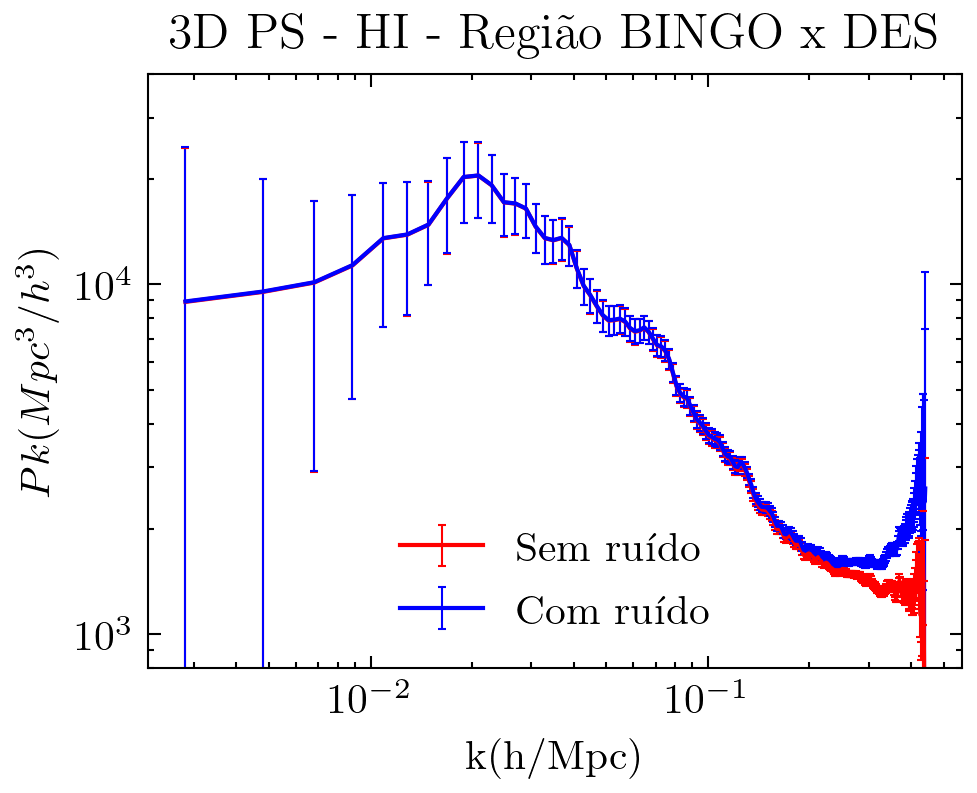

In [ ]:
#plt.loglog(k,Pko * nmesh**3. / np.count_nonzero(o_grid), label='Sem ruído',color='r')
plt.errorbar(k,Pko * nmesh**3. / np.count_nonzero(o_grid),yerr = variance(Pko,Nmodeso,o_grid,nmesh),fmt='',color='r',elinewidth=0.5,capsize=1,capthick=0.5, label='Sem ruído')
#plt.loglog(k,(Pko+pk_thermal) * nmesh**3. / np.count_nonzero(o_grid), label='Com ruído',color='b')
plt.errorbar(k,(Pko+pk_thermal) * nmesh**3. / np.count_nonzero(o_grid),yerr = variance(Pko + pk_thermal,Nmodeso,o_grid,nmesh),fmt='',color='b',elinewidth=0.5,capsize=1,capthick=0.5, label='Com ruído')
plt.legend(loc='lower center')
#plt.xlim(0.01,0.05)
plt.loglog()
plt.ylim(8e+2,4e+4)
plt.xlabel('k(h/Mpc)')
plt.ylabel('$Pk(Mpc^3/h^3)$')
plt.title('3D PS - HI - Região BINGO x DES')
#plt.show()
plt.savefig('/content/drive/MyDrive/imagens/resultados/preview_noise_3d.png',dpi=300)

STEP 4: 1D PS

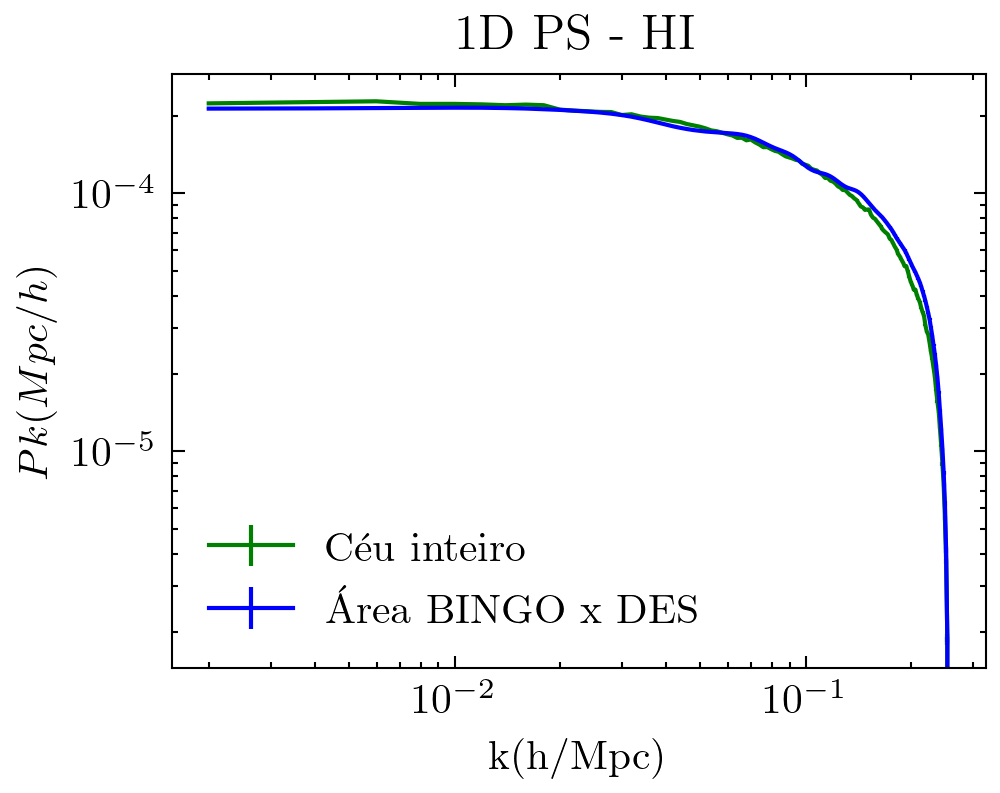

In [ ]:
k1Df      = Pk_full.k1D
Pk1Df     = Pk_full.Pk1D
Nmodes1Df = Pk_full.Nmodes1D

k1Dm      = Pk_mask.k1D
Pk1Dm     = Pk_mask.Pk1D
Nmodes1Dm = Pk_mask.Nmodes1D

k1Do      = Pk_over.k1D
Pk1Do     = Pk_over.Pk1D
Nmodes1Do = Pk_over.Nmodes1D

#plt.loglog(k1Df,Pk1Df * nmesh / np.count_nonzero(d_grid), label='Full Sky',color='g')
plt.errorbar(k1Df,Pk1Df * nmesh / np.count_nonzero(d_grid),yerr = (Pk1Df * nmesh/ np.count_nonzero(d_grid))/((Nmodes1Df)**(1/2)),color='g', label='Céu inteiro')
#plt.loglog(k1Dm,Pk1Dm * nmesh / np.count_nonzero(m_grid), label='Masked',color='b')
plt.errorbar(k1Dm,Pk1Do * nmesh/ np.count_nonzero(o_grid),yerr = (Pk1Do * nmesh/ np.count_nonzero(o_grid))/((Nmodes1Do)**(1/2)),color='b',label='Área BINGO x DES')
#plt.loglog(k1Do,Pk1Do * nmesh / np.count_nonzero(o_grid), label='Over',color='g')
plt.loglog()
#plt.xlim(1e-2,0.1)
#plt.ylim(1e2,1e5)
plt.legend()
plt.xlabel('k(h/Mpc)')
plt.ylabel('$Pk(Mpc/h)$')
#plt.grid()
plt.title('1D PS - HI')
#plt.show()
plt.savefig('/content/drive/MyDrive/imagens/resultados/1d_full_masked.png',dpi=300)

STEP 5: OBTAIN BIAS VALUE


Computing power spectrum of the field...
Time to complete loop = 1.41
Time taken = 1.85 seconds


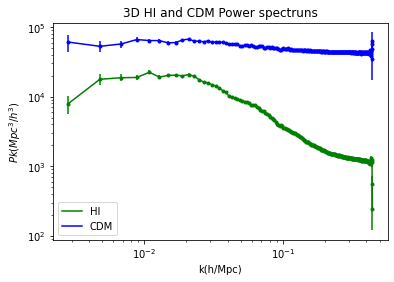

In [ ]:
path_lc = '/content/drive/MyDrive/espectro_potencia/lightcone_bins/'
lc_grid = Field3d(Om0,H0,freq_min,freq_max,number_maps,nside,boxsize,path_lc)

Pk_lc  = PKL.Pk(np.float32(lc_grid), boxsize, axis=0, MAS='None', threads=8)
klc        = Pk_lc.k3D
Pklc      = Pk_lc.Pk[:,0]
Nmodeslc  = Pk_lc.Nmodes3D


plt.loglog(k,Pkf * nmesh**3. / np.count_nonzero(d_grid), label='HI',color='g')
plt.errorbar(k,Pkf * nmesh**3. / np.count_nonzero(d_grid),yerr = (Pkf * nmesh**3. / np.count_nonzero(d_grid))/(Nmodesf)**(1/2),fmt='.',color='g')
plt.loglog(klc,Pklc * nmesh**3. / np.count_nonzero(lc_grid), label='CDM',color='b')
plt.errorbar(klc,Pklc * nmesh**3. / np.count_nonzero(lc_grid),yerr = (Pklc * nmesh**3. / np.count_nonzero(lc_grid))/(Nmodeslc)**(1/2),fmt='.',color='b')
plt.legend()
plt.xlabel('k(h/Mpc)')
plt.ylabel('$Pk(Mpc^3/h^3)$')
plt.title('3D HI and CDM Power spectruns')
plt.savefig('/content/drive/MyDrive/espectro_potencia/imagens/3d_lc_hi',dpi=300)

STEP 6: EXTRACT BAO PROFILE FROM 3D PS

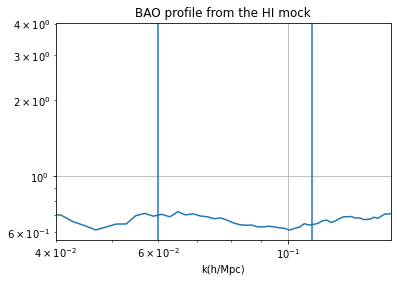

In [ ]:
nonzero_grid = np.count_nonzero(m_grid)
path_no_wiggle = '/content/drive/MyDrive/espectro_potencia/pk_no_wiggle/'
title_plot='BAO profile from the HI mock'
path_savefig = '/content/drive/MyDrive/espectro_potencia/imagens/'
name_fig = 'bao_hi_mock.png'
dpi=300

profile_bao = BAO_profile(Pkm,km,nmesh,nonzero_grid,path_no_wiggle,title_plot,path_savefig,name_fig,dpi)

STEP 7: OBTAIN 2D PS WITHOUT MASK

kpar max: 129
kper max: 182


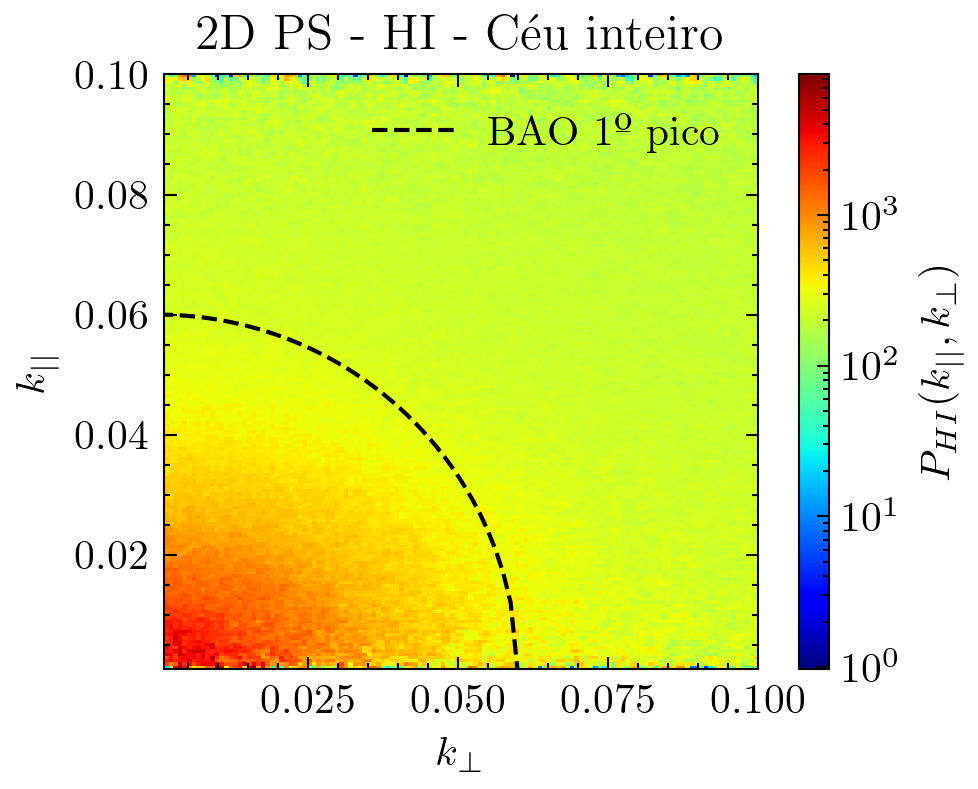

In [ ]:
kpar     = Pk_full.kpar
kper     = Pk_full.kper
Pk2D     = Pk_full.Pk2D

intermed = []
for i in range(0,len(kper)):
  if kpar[i]==kper[i]:
    intermed.append(i)
kpar_max = intermed[1]-intermed[0]-1
kper_max = round(len(kper)/kpar_max)
print('kpar max: '+str(kpar_max))
print('kper max: '+str(kper_max))

pk2d = Pk2D.reshape(kper_max,kpar_max)

x1  = np .linspace(0,0.06)
y1  = np.sqrt(0.06**2 - x1**2)

x2  = np .linspace(0,0.12)
y2  = np.sqrt(0.12**2 - x2**2)

plt.plot(x1,y1,'k--',label='BAO 1º pico')
#plt.plot(x2,y2,'k-.',label='BAO 2º pico')
plt.xlabel(r'$k_{\perp}$')
plt.ylabel(r'$k_{||}$')
#plt.imshow(pk2d*nmesh**2. / np.count_nonzero(o_grid),cmap='jet',origin='lower',norm=LogNorm(),extent=[min(kper),max(kper),min(kpar),max(kpar)])
plt.imshow(pk2d*nmesh**2. / np.count_nonzero(o_grid),cmap='jet',origin='lower',norm=LogNorm(),extent=[min(kper),0.1,min(kpar),0.1])
cbar=plt.colorbar()
cbar.set_label(r'$P_{HI}(k_{||},k_{\perp})$')
plt.title('2D PS - HI - Céu inteiro')
plt.legend()
#plt.show()
plt.savefig('/content/drive/MyDrive/imagens/resultados/2d_full.png',dpi=300)

#gist_rainbow

STEP 8: OBTAIN 2D PS WITH overlap MASK

kpar max: 129
kper max: 182


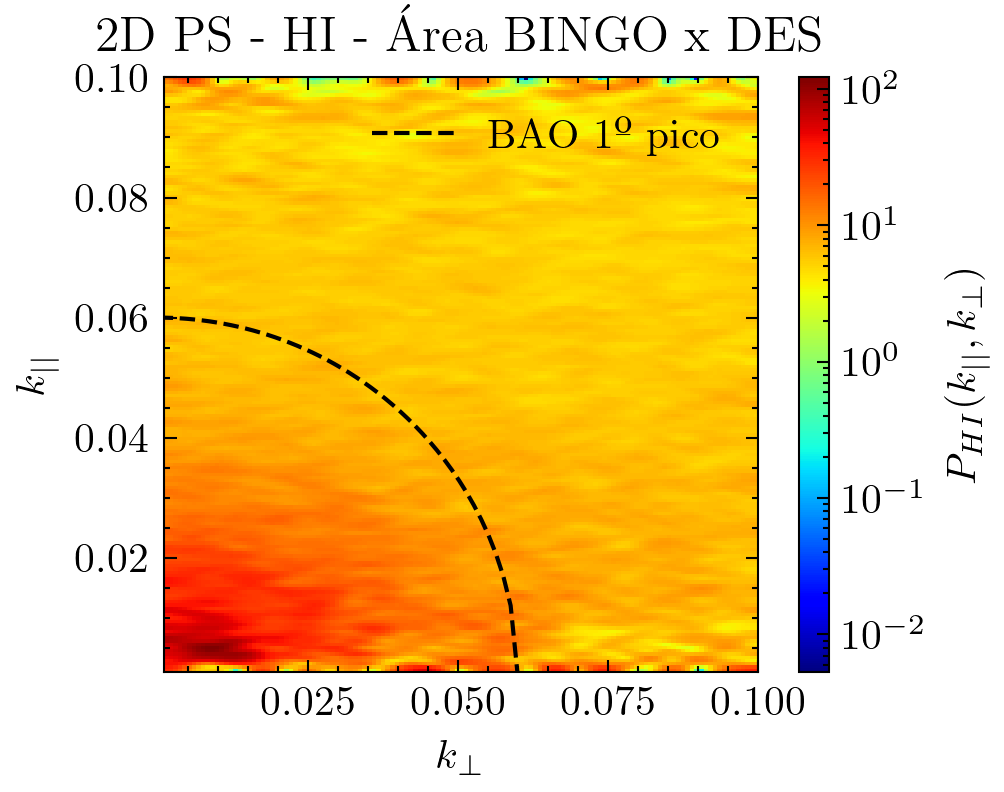

In [ ]:
kpar     = Pk_over.kpar
kper     = Pk_over.kper
Pk2D     = Pk_over.Pk2D

intermed = []
for i in range(0,len(kper)):
  if kpar[i]==kper[i]:
    intermed.append(i)
kpar_max = intermed[1]-intermed[0]-1
kper_max = round(len(kper)/kpar_max)
print('kpar max: '+str(kpar_max))
print('kper max: '+str(kper_max))

pk2d = Pk2D.reshape(kper_max,kpar_max)

x1  = np .linspace(0,0.06)
y1  = np.sqrt(0.06**2 - x1**2)

x2  = np .linspace(0,0.12)
y2  = np.sqrt(0.12**2 - x2**2)

plt.plot(x1,y1,'k--',label='BAO 1º pico')
#plt.plot(x2,y2,'k-.',label='BAO 2º pico')
plt.xlabel(r'$k_{\perp}$')
plt.ylabel(r'$k_{||}$')
#plt.imshow(pk2d*nmesh**2. / np.count_nonzero(o_grid),cmap='jet',origin='lower',norm=LogNorm(),extent=[min(kper),max(kper),min(kpar),max(kpar)])
plt.imshow(pk2d*nmesh**2. / np.count_nonzero(o_grid),cmap='jet',origin='lower',norm=LogNorm(),extent=[min(kper),0.1,min(kpar),0.1])
cbar=plt.colorbar()
cbar.set_label(r'$P_{HI}(k_{||},k_{\perp})$')
plt.title('2D PS - HI - Área BINGO x DES')
plt.legend()
#plt.show()
plt.savefig('/content/drive/MyDrive/imagens/resultados/2d_over_hi.png',dpi=300)

STEP 9: OBTAIN 2D PS WITH BINGO's MASK

kpar max: 129
kper max: 182


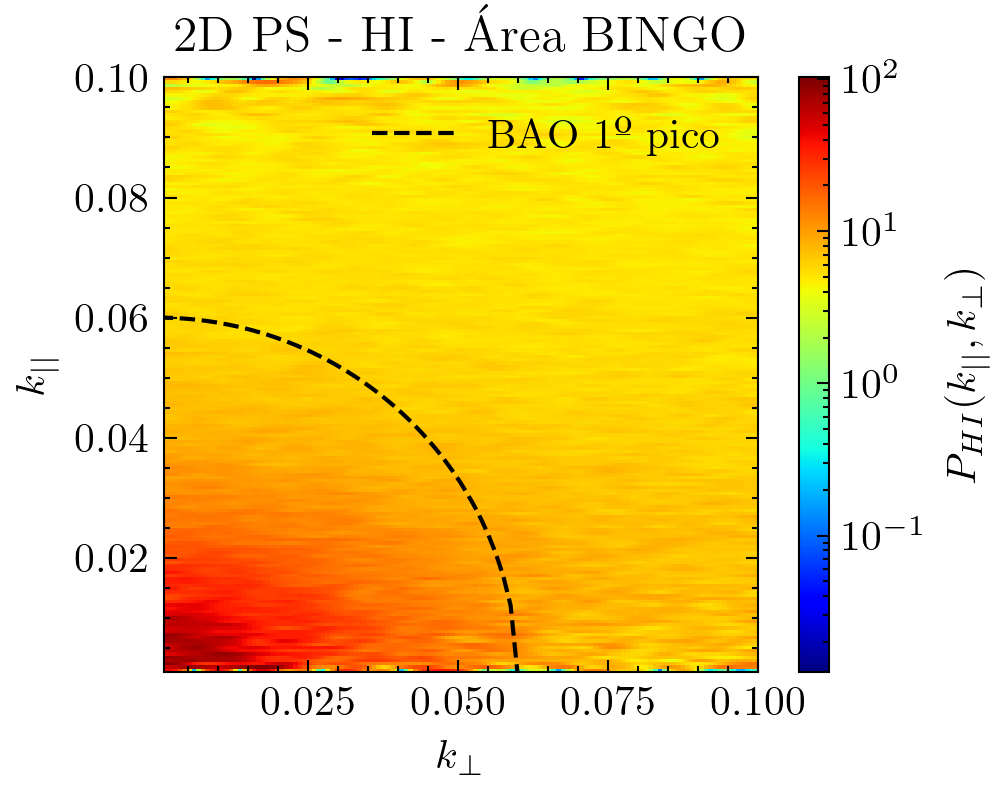

In [ ]:
kpar     = Pk_mask.kpar
kper     = Pk_mask.kper
Pk2D     = Pk_mask.Pk2D
Nmodes2Dm = Pk_mask.Nmodes2D
intermed = []
for i in range(0,len(kper)):
  if kpar[i]==kper[i]:
    intermed.append(i)
kpar_max = intermed[1]-intermed[0]-1
kper_max = round(len(kper)/kpar_max)
print('kpar max: '+str(kpar_max))
print('kper max: '+str(kper_max))

pk2d = Pk2D.reshape(kper_max,kpar_max)

x1  = np .linspace(0,0.06)
y1  = np.sqrt(0.06**2 - x1**2)

x2  = np .linspace(0,0.12)
y2  = np.sqrt(0.12**2 - x2**2)

plt.plot(x1,y1,'k--',label='BAO 1º pico')
#plt.plot(x2,y2,'k-.',label='BAO 2º pico')
plt.xlabel(r'$k_{\perp}$')
plt.ylabel(r'$k_{||}$')
#plt.imshow(pk2d*nmesh**2. / np.count_nonzero(m_grid),cmap='jet',origin='lower',norm=LogNorm(),extent=[min(kper),max(kper),min(kpar),max(kpar)])
plt.imshow(pk2d*nmesh**2. / np.count_nonzero(m_grid),cmap='jet',origin='lower',norm=LogNorm(),extent=[min(kper),0.1,min(kpar),0.1])
cbar=plt.colorbar()
cbar.set_label(r'$P_{HI}(k_{||},k_{\perp})$')
plt.title('2D PS - HI - Área BINGO')
plt.legend()
#plt.show()
plt.savefig('/content/drive/MyDrive/imagens/resultados/2d_bingo_hi.png',dpi=300)

#SECOND PART: GALAXY MOCK
STEP 10: OBTAIN GALAXY 3D FIELD WITH DES MASK

In [8]:
path_gal   = '/content/drive/MyDrive/mapas/des_16_01/dens_total/'
nside=256
nmesh = nside
   
x_corr = np.linspace(0,boxsize-boxsize/nmesh,nmesh) + 0.5*boxsize/nmesh - boxsize/2.
y_corr = np.linspace(0,boxsize-boxsize/nmesh,nmesh) + 0.5*boxsize/nmesh - boxsize/2.
z_corr = np.linspace(0,boxsize-boxsize/nmesh,nmesh) + 0.5*boxsize/nmesh - boxsize/2.

x_grid = np.zeros([nmesh,nmesh,nmesh],dtype=np.float32)
y_grid = np.zeros([nmesh,nmesh,nmesh],dtype=np.float32)
z_grid = np.zeros([nmesh,nmesh,nmesh],dtype=np.float32)
gg_grid = np.zeros([nmesh,nmesh,nmesh],dtype=np.float32)

for i in np.arange(0,nmesh,1):
    for j in np.arange(0,nmesh,1):
        x_grid[i,j,:] = x_corr
        y_grid[i,:,j] = y_corr
        z_grid[:,i,j] = z_corr

r_grid = np.sqrt(x_grid**2.+y_grid**2.+z_grid**2.)
p_grid = hp.vec2pix(256,x_grid,y_grid,z_grid)

for i in np.arange(0,number_maps,1):
    real_tb = np.load(path_gal+str(i)+'Mhz.npy')
    delta_tb = real_tb/np.average(real_tb) - 1.
    np.float32(delta_tb)
    r_filter = (r_grid > distance[i+1]) & (r_grid <= distance[i])
    gg_grid = gg_grid + delta_tb[p_grid] * r_filter
gg_grid = gg_grid.astype(np.float32)
print('Full sky 3D field calculated')

#boxsize = box_size
x_corr = np.linspace(0,boxsize-boxsize/nmesh,nmesh) + 0.5*boxsize/nmesh - boxsize/2.
y_corr = np.linspace(0,boxsize-boxsize/nmesh,nmesh) + 0.5*boxsize/nmesh - boxsize/2.
z_corr = np.linspace(0,boxsize-boxsize/nmesh,nmesh) + 0.5*boxsize/nmesh - boxsize/2.

x_grid = np.zeros([nmesh,nmesh,nmesh],dtype=np.float32)
y_grid = np.zeros([nmesh,nmesh,nmesh],dtype=np.float32)
z_grid = np.zeros([nmesh,nmesh,nmesh],dtype=np.float32)
d_grid = np.zeros([nmesh,nmesh,nmesh],dtype=np.float32)
g_grid = np.zeros([nmesh,nmesh,nmesh],dtype=np.float32)

for i in np.arange(0,nmesh,1):
    for j in np.arange(0,nmesh,1):
        x_grid[i,j,:] = x_corr
        y_grid[i,:,j] = y_corr
        z_grid[:,i,j] = z_corr

r_grid = np.sqrt(x_grid**2.+y_grid**2.+z_grid**2.)
p_grid = hp.vec2pix(256,x_grid,y_grid,z_grid)


for i in np.arange(0,number_maps,1):
    mask = hp.read_map(path_over)
    real_tb = np.load(path_gal+str(i)+'Mhz'+'.npy')
    if np.average(real_tb) == 0:
        delta_tb=real_tb*0
        print('One of your maps was zero, but I accepted')
    else:
        delta_tb = real_tb/np.average(real_tb) - 1
        
    for j in range(0,len(mask)):
        if mask[j]<=0:
            delta_tb[j]=0
    np.float32(delta_tb)
    r_filter = (r_grid > distance[i+1]) & (r_grid <= distance[i])
    g_grid = g_grid + delta_tb[p_grid] * r_filter
print('Masked 3D field calculated')

gal_grid = g_grid.astype(np.float32)
#gal_grid = Field3d_masked(Om0,H0,freq_min,freq_max,number_maps,nside,boxsize,path_gal,path_des)  #3D MASKED FIELD

Full sky 3D field calculated
Masked 3D field calculated


Espectro do CAMB para fazer comparações

In [ ]:
cp = camb.CAMBparams()
cp.set_cosmology(H0=72.0,ombh2=0.044*0.72**2.,omch2=(0.26-0.044)*0.72**2.,num_massive_neutrinos=0,mnu=0.0)
cp.InitPower.set_params(As=2.0824e-9, ns=0.96)
cp.Nonlinear = camb.model.NonLinear_none
cp.WantTransfer = True
cp.set_matter_power(kmax=10.0,redshifts=(0.0,0.1,0.2,0.3,0.4,0.5))
result = camb.get_results(cp)
#kh, z, Pkc = result.get_matter_power_spectrum(minkh=k[0], maxkh=k[220], npoints = 221)
#kh, z, Pkc = result.get_matter_power_spectrum(minkh=0.002, maxkh=0.2, npoints = 221)
cp.NonLinear = camb.model.NonLinear_both
result.calc_power_spectra(cp)
kh_nonlin, z_nonlin, pk_nonlin = result.get_matter_power_spectrum(minkh=km[0], maxkh=km[220], npoints = 221)
#kh_nonlin, z_nonlin, pk_nonlin = result.get_matter_power_spectrum(minkh=0.002, maxkh=0.2, npoints = 221)

Note: redshifts have been re-sorted (earliest first)


STEP 11: CALCULE 3D GALAXY PS

In [9]:
#full sky
Pk_gg = PKL.Pk(np.float32(gg_grid), boxsize, axis=0, MAS='None', threads=8)
kgg      = Pk_gg.k3D
Pkgg     = Pk_gg.Pk[:,0]
Nmodesgg = Pk_gg.Nmodes3D 

#partial sky
Pk_gal = PKL.Pk(np.float32(gal_grid), boxsize, axis=0, MAS='None', threads=8)
kg      = Pk_gal.k3D
Pkg     = Pk_gal.Pk[:,0]
Nmodesg = Pk_gal.Nmodes3D*fskyo      #One must multiply by the fsky to obtain the correct number of modes in the partial sky case


Computing power spectrum of the field...
Time to complete loop = 0.73
Time taken = 1.04 seconds

Computing power spectrum of the field...
Time to complete loop = 0.72
Time taken = 1.01 seconds


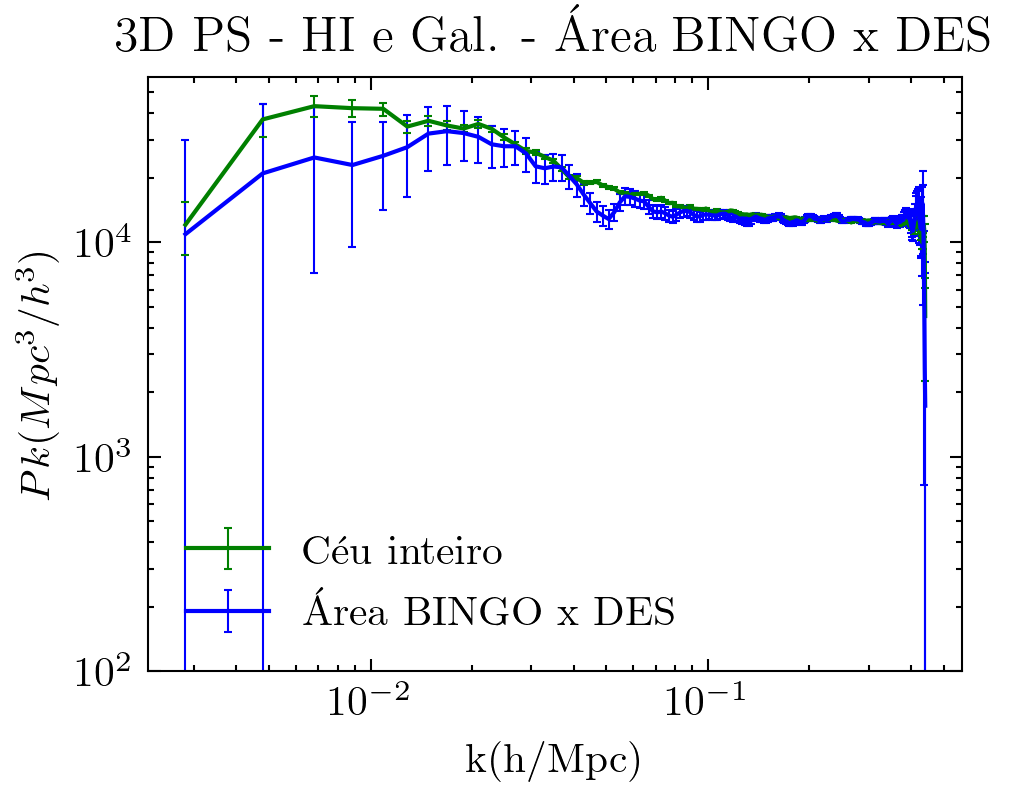

In [ ]:
plt.errorbar(kg,Pkgg * nmesh**3. / np.count_nonzero(gg_grid),yerr = (Pkgg * nmesh**3. / np.count_nonzero(gg_grid))/(Nmodesgg)**(1/2),fmt='',color='g',elinewidth=0.5,capsize=1,capthick=0.5,label='Céu inteiro')
#plt.loglog(kg,(Pkg) * nmesh**3. / np.count_nonzero(gal_grid), label='Gal.',color='b')
plt.errorbar(kg,Pkg * nmesh**3. / np.count_nonzero(gal_grid),yerr = (Pkg* nmesh**3. / np.count_nonzero(gal_grid))/(Nmodeso)**(1/2),fmt='',color='b',elinewidth=0.5,capsize=1,capthick=0.5, label='Área BINGO x DES')
#plt.loglog(kx,Pk0_x * nmesh**3. / (np.count_nonzero(o_grid)), label='HI x Gal.',color='g')
#plt.errorbar(kx,Pk0_x * nmesh**3. / np.count_nonzero(o_grid),yerr = (np.sqrt(Pk0_x**2 +Pko*Pkg) * nmesh**3. / np.count_nonzero(o_grid))/(2*Nmodeso)**(1/2),fmt='',color='g',elinewidth=0.5,capsize=1,capthick=0.5)
plt.loglog()
plt.legend()
#plt.xlim(0.01,0.05)
plt.ylim(1e+2)
plt.xlabel('k(h/Mpc)')
plt.ylabel('$Pk(Mpc^3/h^3)$')
plt.title('3D PS - HI e Gal. - Área BINGO x DES')
plt.show()

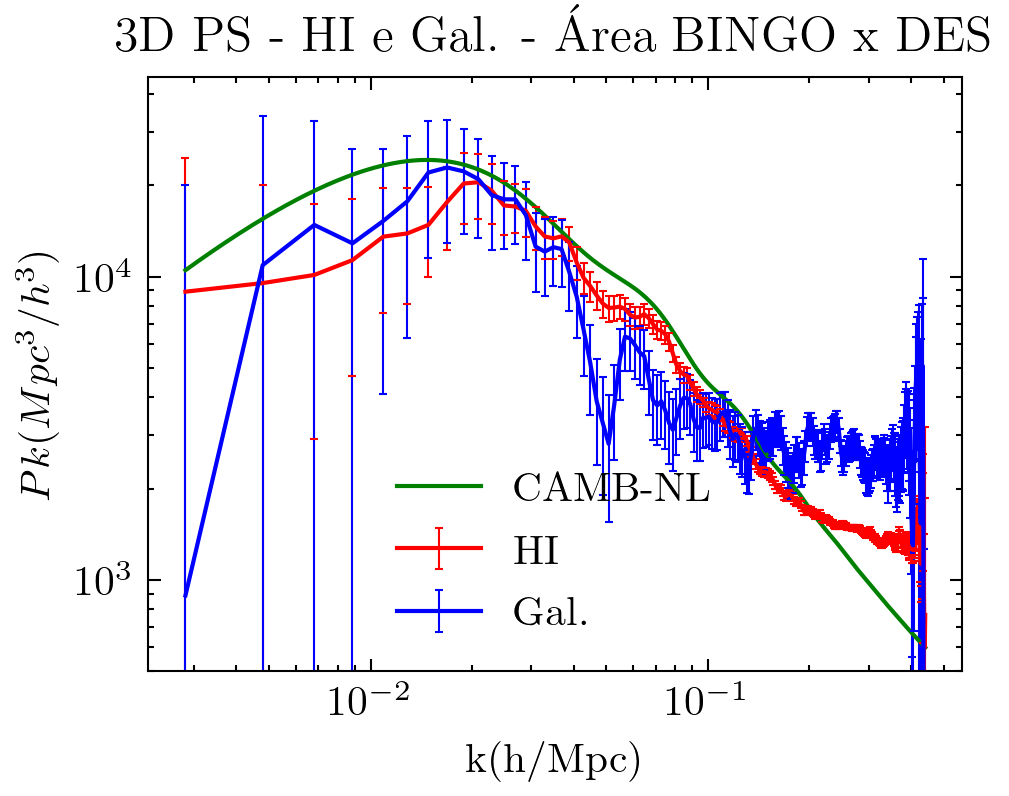

In [ ]:


#plt.loglog(k,Pko * nmesh**3. / np.count_nonzero(o_grid), label='HI ',color='r')
plt.loglog(kh_nonlin,pk_nonlin[2],label='CAMB-NL',color='g')
plt.errorbar(k,Pko * nmesh**3. / np.count_nonzero(o_grid),yerr = (Pko * nmesh**3. / np.count_nonzero(o_grid))/(Nmodeso)**(1/2),fmt='',color='r',elinewidth=0.5,capsize=1,capthick=0.5,label='HI')
#plt.loglog(kg,(Pkg) * nmesh**3. / np.count_nonzero(gal_grid), label='Gal.',color='b')
plt.errorbar(kg,Pkg * nmesh**3. / np.count_nonzero(gal_grid) -(1.7 / 0.00017),yerr = (Pkg* nmesh**3. / np.count_nonzero(gal_grid))/(Nmodeso)**(1/2),fmt='',color='b',elinewidth=0.5,capsize=1,capthick=0.5, label='Gal.')
#plt.loglog(kx,Pk0_x * nmesh**3. / (np.count_nonzero(o_grid)), label='HI x Gal.',color='g')
#plt.errorbar(kx,Pk0_x * nmesh**3. / np.count_nonzero(o_grid),yerr = (np.sqrt(Pk0_x**2 +Pko*Pkg) * nmesh**3. / np.count_nonzero(o_grid))/(2*Nmodeso)**(1/2),fmt='',color='g',elinewidth=0.5,capsize=1,capthick=0.5)
plt.loglog()
plt.legend(loc='lower center')
#plt.xlim(0.01,0.05)
plt.ylim(5e+2)
plt.xlabel('k(h/Mpc)')
plt.ylabel('$Pk(Mpc^3/h^3)$')
plt.title('3D PS - HI e Gal. - Área BINGO x DES')
plt.show()
#plt.savefig('/content/drive/MyDrive/imagens/resultados/3d_hi_gal.png',dpi=300)


STEP 12: CALCULE 1D GALAXY PS

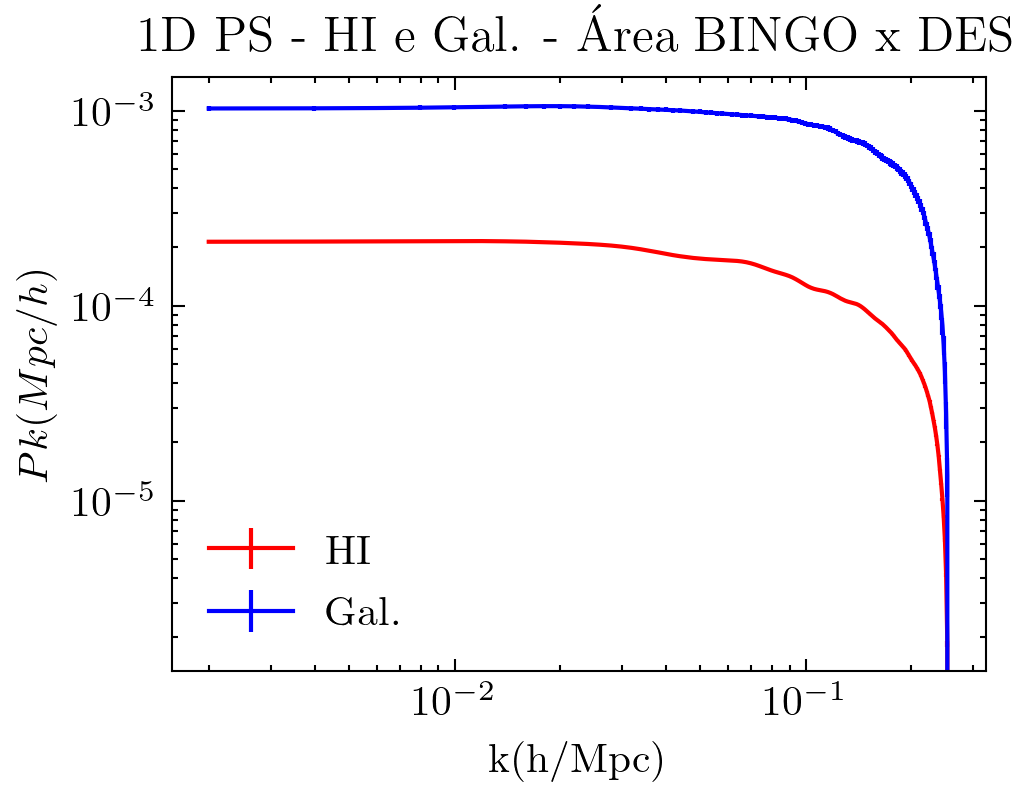

In [ ]:
k1Dg      = Pk_gal.k1D
Pk1Dg     = Pk_gal.Pk1D
Nmodes1Dg = Pk_gal.Nmodes1D*fskyo

#plt.loglog(k1Dm,Pk1Dm * nmesh / np.count_nonzero(m_grid), label='HI partial sky',color='b')
plt.errorbar(k1Do,Pk1Do * nmesh/ np.count_nonzero(o_grid),yerr = (Pk1Do * nmesh/ np.count_nonzero(o_grid))/((Nmodes1Do)**(1/2)),color='r',label='HI')
#plt.loglog(k1Dg,Pk1Dg * nmesh / np.count_nonzero(gal_grid), label='DES-like mock',color='r')
plt.errorbar(k1Dg,Pk1Dg * nmesh/ np.count_nonzero(gal_grid),yerr = (Pk1Dg * nmesh/ np.count_nonzero(gal_grid))/((Nmodes1Dg)**(1/2)),color='b',label='Gal.')
#plt.xlim(1e-2,0.1)
#plt.ylim(1e2,1e5)
plt.loglog()
plt.legend()
plt.xlabel('k(h/Mpc)')
plt.ylabel('$Pk(Mpc/h)$')
#plt.grid()
plt.title('1D PS - HI e Gal. - Área BINGO x DES')
#plt.show()
plt.savefig('/content/drive/MyDrive/imagens/resultados/1d_hi_gal.png',dpi=300)



STEP 13: CALCULE 2D GALAXY PS

kpar max: 129
kper max: 182


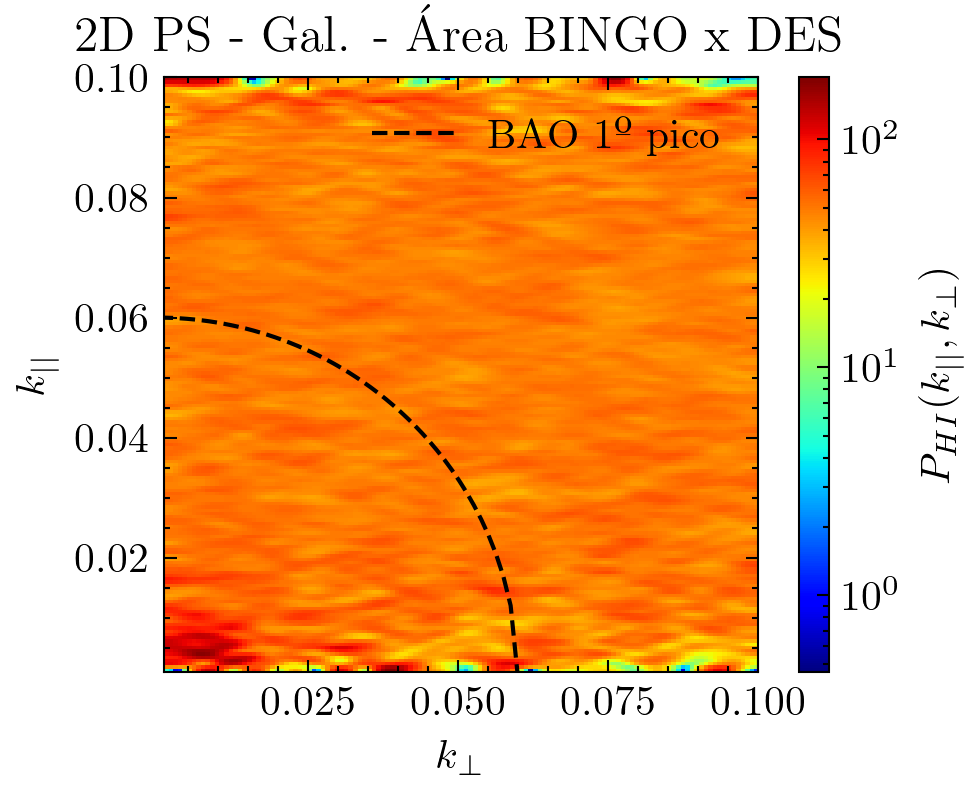

In [ ]:
kpar     = Pk_gal.kpar
kper     = Pk_gal.kper
Pk2D     = Pk_gal.Pk2D

intermed = []
for i in range(0,len(kper)):
  if kpar[i]==kper[i]:
    intermed.append(i)
kpar_max = intermed[1]-intermed[0]-1
kper_max = round(len(kper)/kpar_max)
print('kpar max: '+str(kpar_max))
print('kper max: '+str(kper_max))

pk2d = Pk2D.reshape(kper_max,kpar_max)

x1  = np .linspace(0,0.06)
y1  = np.sqrt(0.06**2 - x1**2)

x2  = np .linspace(0,0.12)
y2  = np.sqrt(0.12**2 - x2**2)

plt.plot(x1,y1,'k--',label='BAO 1º pico')
#plt.plot(x2,y2,'k-.',label='BAO 2º pico')
plt.xlabel(r'$k_{\perp}$')
plt.ylabel(r'$k_{||}$')
#plt.imshow(pk2d*nmesh**2. / np.count_nonzero(gal_grid),cmap='jet',origin='lower',norm=LogNorm(),extent=[min(kper),max(kper),min(kpar),max(kpar)])
plt.imshow(pk2d*nmesh**2. / np.count_nonzero(gal_grid),cmap='jet',origin='lower',norm=LogNorm(),extent=[min(kper),0.1,min(kpar),0.1])
cbar=plt.colorbar()
cbar.set_label(r'$P_{HI}(k_{||},k_{\perp})$')
plt.title('2D PS - Gal. - Área BINGO x DES')
plt.legend()
#plt.show()
plt.savefig('/content/drive/MyDrive/imagens/resultados/2d_gal.png',dpi=300) 

kpar max: 129
kper max: 182


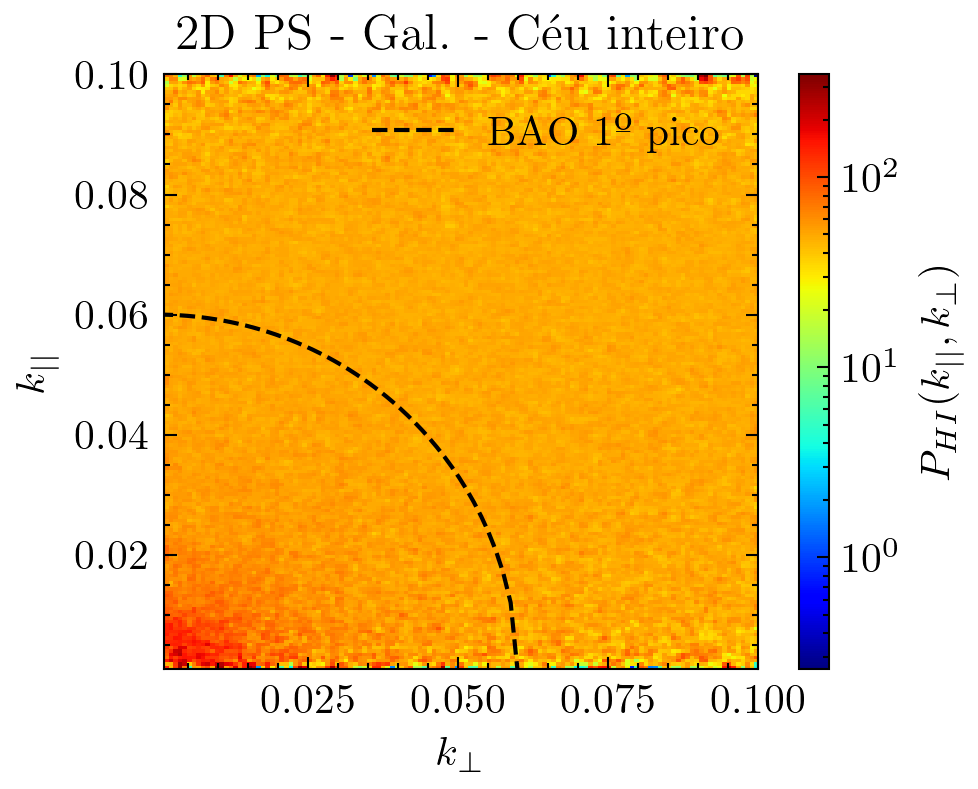

In [10]:
kpar     = Pk_gg.kpar
kper     = Pk_gg.kper
Pk2D     = Pk_gg.Pk2D

intermed = []
for i in range(0,len(kper)):
  if kpar[i]==kper[i]:
    intermed.append(i)
kpar_max = intermed[1]-intermed[0]-1
kper_max = round(len(kper)/kpar_max)
print('kpar max: '+str(kpar_max))
print('kper max: '+str(kper_max))

pk2d = Pk2D.reshape(kper_max,kpar_max)

x1  = np .linspace(0,0.06)
y1  = np.sqrt(0.06**2 - x1**2)

x2  = np .linspace(0,0.12)
y2  = np.sqrt(0.12**2 - x2**2)

plt.plot(x1,y1,'k--',label='BAO 1º pico')
#plt.plot(x2,y2,'k-.',label='BAO 2º pico')
plt.xlabel(r'$k_{\perp}$')
plt.ylabel(r'$k_{||}$')
#plt.imshow(pk2d*nmesh**2. / np.count_nonzero(gal_grid),cmap='jet',origin='lower',norm=LogNorm(),extent=[min(kper),max(kper),min(kpar),max(kpar)])
plt.imshow(pk2d*nmesh**2. / np.count_nonzero(gg_grid),cmap='jet',origin='lower',norm=LogNorm(),extent=[min(kper),0.1,min(kpar),0.1])
cbar=plt.colorbar()
cbar.set_label(r'$P_{HI}(k_{||},k_{\perp})$')
plt.title('2D PS - Gal. - Céu inteiro')
plt.legend()
#plt.show()
plt.savefig('/content/drive/MyDrive/imagens/resultados/2d_gal_full.png',dpi=300) 

#THIRD PART: CROSS-CORRELATIONS
STEP 14: OBTAIN HI AND GALAXY 3D FIELD WITH THE OVERLAP MASK

In [ ]:
#o_grid = o_grid.astype(np.float32)
Pkx   = PKL.XPk([gal_grid.astype(np.float32),o_grid.astype(np.float32)], boxsize, axis=0, MAS='None', threads=8)
kx     = Pkx.k3D
Pk0_x  = Pkx.XPk[:,0,0]


Computing power spectra of the fields...
Time FFTS = 0.38
Time loop = 0.78
Time taken = 1.17 seconds


STEP 15: CALCULE 3D CROSS PS WITH ERROR BARS

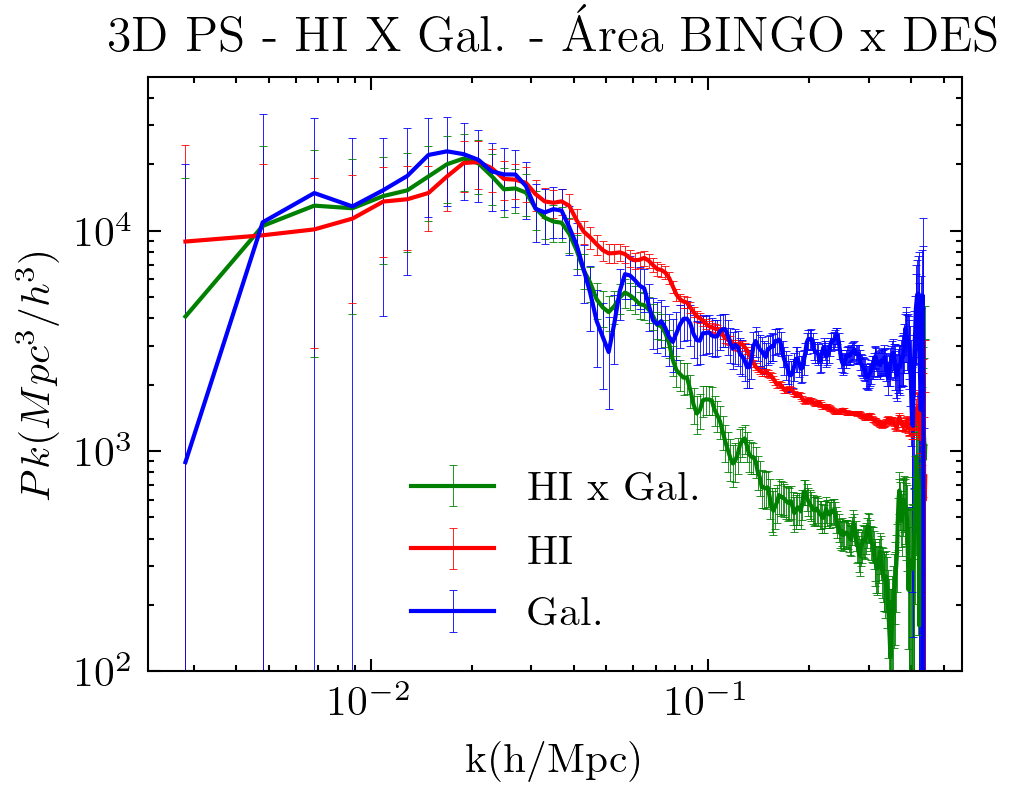

In [ ]:
plt.errorbar(kx,Pk0_x * nmesh**3. / np.count_nonzero(o_grid),yerr = (np.sqrt(Pk0_x**2 +Pko*Pkg) * nmesh**3. / np.count_nonzero(o_grid))/(2*Nmodeso)**(1/2),fmt='',color='g',elinewidth=0.2,capsize=1,capthick=0.2,label='HI x Gal.')
plt.errorbar(k,Pko * nmesh**3. / np.count_nonzero(o_grid),yerr = (Pko * nmesh**3. / np.count_nonzero(o_grid))/(Nmodeso)**(1/2),fmt='',color='r',elinewidth=0.2,capsize=1,capthick=0.2,label='HI')
plt.errorbar(kg,Pkg * nmesh**3. / np.count_nonzero(gal_grid) -(1.7 / 0.00017),yerr = (Pkg* nmesh**3. / np.count_nonzero(gal_grid))/(Nmodeso)**(1/2),fmt='',color='b',elinewidth=0.2,capsize=1,capthick=0.2, label='Gal.')
plt.loglog()
plt.legend()
#plt.xlim(0.01,0.05)
plt.ylim(1e+2)
plt.xlabel('k(h/Mpc)')
plt.ylabel('$Pk(Mpc^3/h^3)$')
plt.title('3D PS - HI X Gal. - Área BINGO x DES')
#plt.show()
plt.savefig('/content/drive/MyDrive/imagens/resultados/3d_hixgal.png',dpi=300)



STEP 16: CALCULE 2D CROSS PS

kpar max: 129
kper max: 182


<ipython-input-180-5531ffa4c167>:27: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  plt.imshow(pk2d*nmesh**2. / np.count_nonzero(o_grid),cmap='jet',origin='lower',norm=SymLogNorm(100),extent=[min(kper),0.1,min(kpar),0.1])


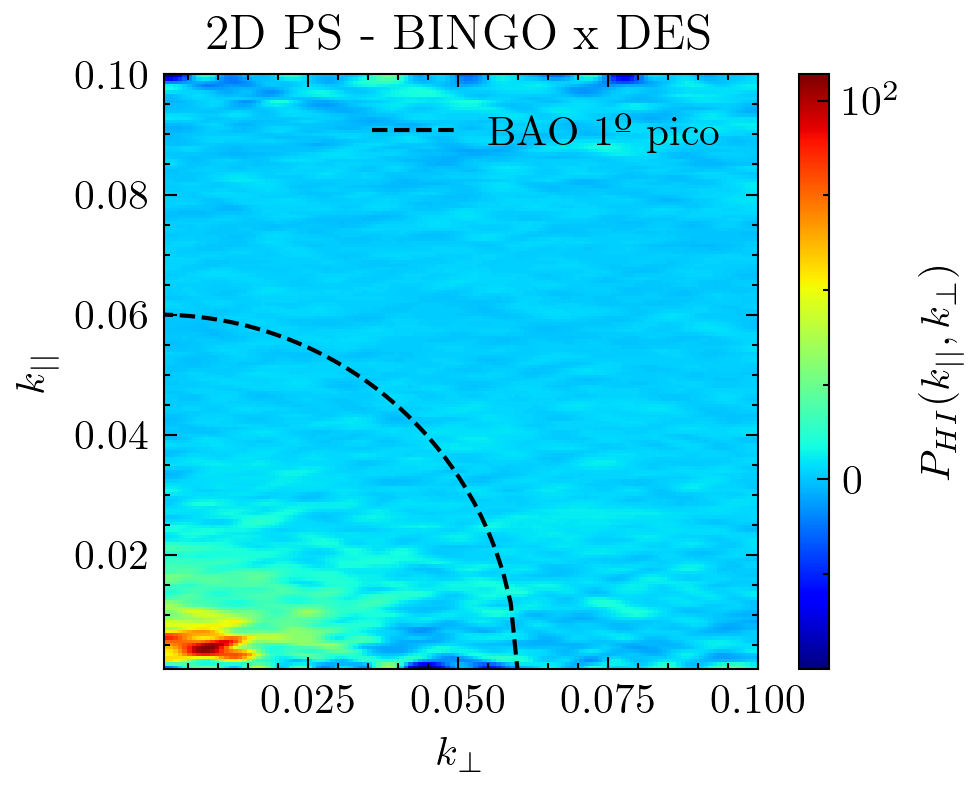

In [ ]:
kpar     = Pkx.kpar
kper     = Pkx.kper
Pk2D     = Pkx.PkX2D[:,0]

intermed = []
for i in range(0,len(kper)):
  if kpar[i]==kper[i]:
    intermed.append(i)
kpar_max = intermed[1]-intermed[0]-1
kper_max = round(len(kper)/kpar_max)
print('kpar max: '+str(kpar_max))
print('kper max: '+str(kper_max))

pk2d = Pk2D.reshape(kper_max,kpar_max)

x1  = np .linspace(0,0.06)
y1  = np.sqrt(0.06**2 - x1**2)

x2  = np .linspace(0,0.12)
y2  = np.sqrt(0.12**2 - x2**2)

plt.plot(x1,y1,'k--',label='BAO 1º pico')
#plt.plot(x2,y2,'k-.',label='BAO 2º pico')
plt.xlabel(r'$k_{\perp}$')
plt.ylabel(r'$k_{||}$')
#plt.imshow(pk2d*nmesh**2. / np.count_nonzero(o_grid),cmap='jet',origin='lower',norm=LogNorm(),extent=[min(kper),max(kper),min(kpar),max(kpar)])
plt.imshow(pk2d*nmesh**2. / np.count_nonzero(o_grid),cmap='jet',origin='lower',norm=SymLogNorm(100),extent=[min(kper),0.1,min(kpar),0.1])
cbar=plt.colorbar()
cbar.set_label(r'$P_{HI}(k_{||},k_{\perp})$')
plt.title('2D PS - BINGO x DES')
#,norm=LogNorm()
plt.legend()
#plt.show()
plt.savefig('/content/drive/MyDrive/imagens/resultados/2d_cross.png',dpi=300)

STEP 17: OBTAIN HI THERMAL AND GALAXY 3D FIELD WITH THE OVERLAP MASK


STEP 18: PLOT CORRELATION COEFFICIENT

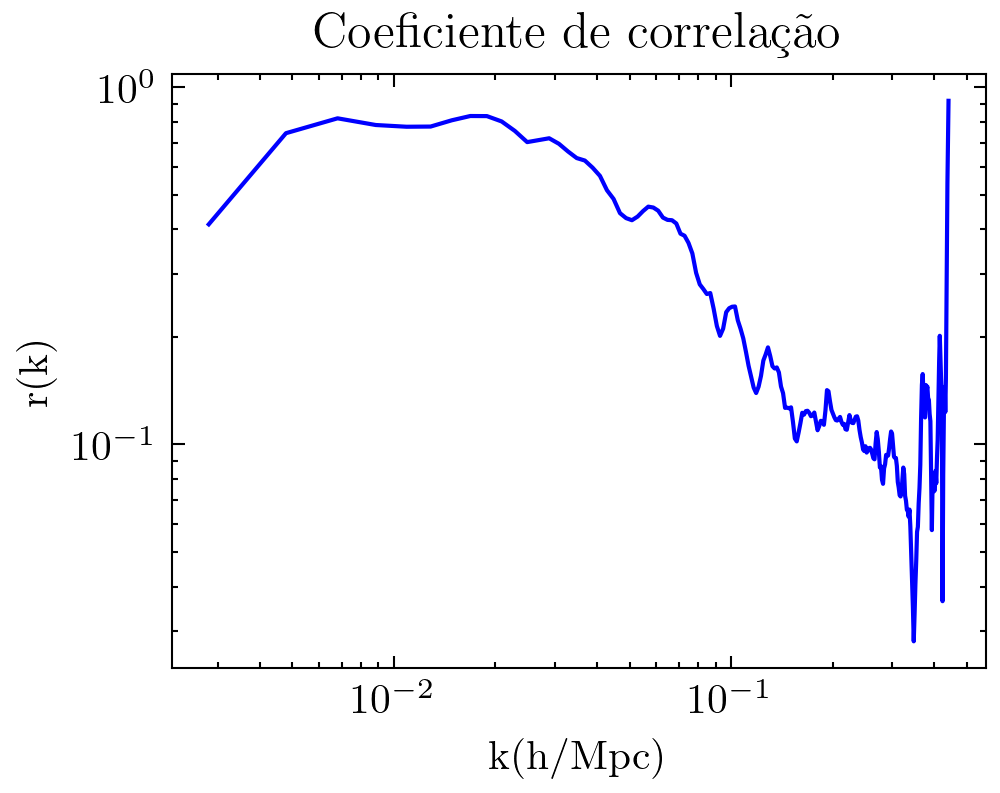

In [ ]:
plt.loglog(k,Pk0_x/np.sqrt(Pko*Pkg),color='b')
plt.title('Coeficiente de correlação')
plt.xlabel('k(h/Mpc)')
plt.ylabel('r(k)')
#plt.show()
plt.savefig('/content/drive/MyDrive/imagens/resultados/cross_coef.png',dpi=300)

STEP 19: EFFECTIVE SCALE DETERMINATION

In [ ]:
def KEFF(signal,noise,k):
  sn = signal/noise
  keff = np.sum(k*sn*sn)/np.sum(sn*sn)
  return keff
#teste
noise = variance(Pko,Nmodeso,o_grid,nmesh)
signal = Pko

keff = KEFF(signal,noise,k)
print(keff)

0.2452583428485393
